In [1]:
import pickle
import numpy as np
#import librosa
import os
import tqdm
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
import matplotlib
import matplotlib.pyplot as plt

from os.path import isfile, join
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, classification_report
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
import itertools
from IPython.display import display

%matplotlib inline

/home/studio-lab-user/.conda/envs/env/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
#ICP_PATH = "/content/drive/MyDrive/Thesis/IEMOCAP/"
home_path = os.getcwd() + '/'
#AIBO_PATH = "/content/drive/MyDrive/Thesis/AIBO/"
ICP_PATH = home_path + "/data/IEMOCAP/wav2vec/"

In [4]:
model_option = 'xlsr' 

In [5]:
x_train_trn = np.load(ICP_PATH+ model_option+ "_icp_ft_train.npy")
x_train_vld = np.load(ICP_PATH + model_option + "_icp_ft_val.npy")
X_train = np.vstack([x_train_trn, x_train_vld])

y_train_trn = np.load(ICP_PATH + model_option+ "_icp_lb_train.npy", allow_pickle=True)
y_train_vld = np.load(ICP_PATH + model_option + "_icp_lb_val.npy", allow_pickle=True)
y_train = np.hstack([y_train_trn, y_train_vld])

In [6]:
X_test = np.load(ICP_PATH + model_option + "_icp_ft_test.npy")
y_test = np.load(ICP_PATH + model_option + "_icp_lb_test.npy", allow_pickle=True)

In [7]:
#FT_PATH = ICP_PATH + "aibo_ft.npy"
#LABELS_PATH = ICP_PATH + "aibo_labels.npy"
#df = np.load(FT_PATH)
#df = np.load("/Users/el/embrace/data/data_wav2vec2/icp/" + "icp_hs.npy")
#labels_df = np.load(LABELS_PATH)

In [8]:
CLASS_TO_ID = {"neu": 0, "hap": 1, "sad": 2, "fru": 3, "ang": 4}
ID_TO_CLASS = {v: k for k, v in CLASS_TO_ID.items()}
w2v_classes = list(ID_TO_CLASS.keys())
w2v_classes
#lb_df = np.array([CLASS_TO_ID[letter] for letter in labels_df])

[0, 1, 2, 3, 4]

In [9]:
#print(np.unique(lb_df))

In [10]:
#unique, counts = np.unique(labels_df, return_counts=True)
#dict(zip(unique, counts))

In [11]:
#my_x = df
#my_y = lb_df

#X_train, X_test, y_train, y_test = train_test_split(my_x, my_y, test_size=0.33, random_state=42)

#split_index = int(my_y.shape[0]*0.8)
#all_indexes = list(range(my_x.shape[0]))
#test_indexes = all_indexes[(split_index + 1):]
#X_test = my_x[test_indexes]
#y_test = my_y[test_indexes]

#train_indexes = all_indexes[:(split_index + 1)]
#X_train = my_x[train_indexes]
#y_train = my_y[train_indexes]

#eval_split_index = 934
#all_indexes = list(range(X_train.shape[0]))
#eval_indexes = all_indexes[(eval_split_index + 1):]
#eval_train_indexes = all_indexes[:(eval_split_index + 1)]

#X_train_eval = X_train[eval_indexes]
#y_train_eval = y_train[eval_indexes]
#x_eval = X_train[eval_train_indexes]
#y_eval = y_train[eval_train_indexes]

# X_train_eval=np.vstack(X_train_eval).astype(np.float)
# y_train_eval=np.vstack(y_train_eval).astype(np.str)

# print(y_train_eval.shape, y_eval.shape, y_test.shape)       # (4696,) (935,) (1407,)
# print(X_train_eval.shape, x_eval.shape, X_test.shape)       # (4696, 3072) (935, 3072) (1407, 3072)

#train_dataset = TensorDataset(torch.tensor(X_train_eval), torch.tensor(y_train_eval))  # create your dataset
#train_dataset = TensorDataset(torch.from_numpy(X_train_eval).float(), torch.from_numpy(y_train_eval).float())
#eval_dataset = TensorDataset(torch.tensor(x_eval), torch.tensor(y_eval))  # create your dataset
#test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

#train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
#valid_loader = DataLoader(dataset=eval_dataset, batch_size=128, shuffle=False)
#test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)


In [12]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5868, 3072)
(5868,)
(1512, 3072)
(1512,)


In [13]:
def min_max_scaling(col):
    return (col - col.min())/(col.max()-col.min())

In [14]:
for col in range(X_train.shape[1]):
    X_train[col] = min_max_scaling(X_train[col])

In [15]:
X_train

array([[ 7.69469365e-02,  6.66742250e-02,  9.31248516e-02, ...,
         1.15098163e-01,  1.28664628e-01,  1.12677865e-01],
       [ 3.12073547e-02,  2.61426847e-02,  2.98637059e-02, ...,
         4.38158847e-02,  6.53981864e-02,  4.31308076e-02],
       [ 4.23047058e-02,  3.88826504e-02,  4.72520180e-02, ...,
         6.93552494e-02,  1.25301421e-01,  6.21320419e-02],
       ...,
       [ 1.41835198e-01, -4.62522984e-01, -2.58707721e-02, ...,
         1.51740062e+00,  5.59904194e+00,  1.44006312e+00],
       [ 1.76113427e-01, -6.18074477e-01, -3.93590420e-01, ...,
         1.85114336e+00,  6.22531605e+00,  1.92419970e+00],
       [ 7.63968676e-02, -4.90954161e-01, -1.59908741e-04, ...,
         1.48735905e+00,  9.37830329e-01,  1.50027156e+00]], dtype=float32)

In [16]:
def plot_confusion_matrix(cm, classes, normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.RdPu):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title + " for " + model)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #if normalize:
    #    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
     #   print("Normalized confusion matrix")
    #else:
     #   print('Confusion matrix, without normalization')
    #print('Confusion matrix')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(home_path + 'skl_res/ICP/conf_matrix_{}_{}.png'.format("icp", model))
    plt.show()
    return cm
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred_probs), len(CLASS_TO_ID))

    acc = 'Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred))
    fscore = 'Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro'))
    prec = 'Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro'))
    rec = 'Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro'))
    metrics = [acc, fscore, prec, rec]
    #if cm:
    cr = classification_report(y_true=y_test, y_pred=pred, target_names=list(ID_TO_CLASS.values()), zero_division=1)
    cm = plot_confusion_matrix(confusion_matrix(y_test, pred), classes=list(ID_TO_CLASS.values()))
    f = open(home_path + 'skl_res/ICP/report_{}_{}.txt'.format('icp', model), 'w')
    f.write('RESULTS\n\nMetrics\n\n{}\n\nClassification Report\n\n{}\n\nConfusion Matrix\n\n{}\n'.format(metrics, cr, cm))
    f.close()
    print(cr)

In [17]:
list(ID_TO_CLASS.keys())

[0, 1, 2, 3, 4]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


building tree 1 of 100
building tree 2 of 100building tree 3 of 100
building tree 4 of 100

building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.7s


building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100building tree 48 of 100

building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


(1512,)
(1512, 5)


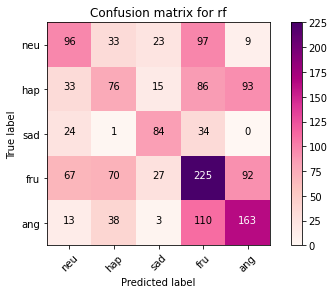

              precision    recall  f1-score   support

         neu       0.41      0.37      0.39       258
         hap       0.35      0.25      0.29       303
         sad       0.55      0.59      0.57       143
         fru       0.41      0.47      0.44       481
         ang       0.46      0.50      0.48       327

    accuracy                           0.43      1512
   macro avg       0.44      0.44      0.43      1512
weighted avg       0.42      0.43      0.42      1512



In [18]:
rf_classifier = RandomForestClassifier(n_estimators = 100,verbose=3,n_jobs=-1)
rf_classifier.fit(X_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(X_test)

# Results
print(y_test.shape)
print(pred_probs.shape)
model = 'rf'
display_results(y_test, pred_probs)

with open(home_path + 'skl_res/ICP/rf_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

/home/studio-lab-user/.conda/envs/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


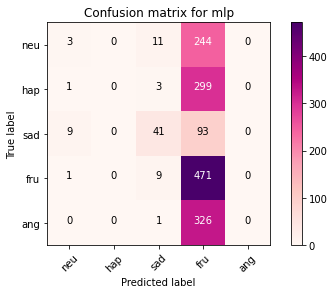

              precision    recall  f1-score   support

         neu       0.21      0.01      0.02       258
         hap       1.00      0.00      0.00       303
         sad       0.63      0.29      0.39       143
         fru       0.33      0.98      0.49       481
         ang       1.00      0.00      0.00       327

    accuracy                           0.34      1512
   macro avg       0.63      0.26      0.18      1512
weighted avg       0.62      0.34      0.20      1512



In [19]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(650, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.01,
                               power_t=0.5, max_iter=1000, shuffle=True, random_state=None, tol=0.0001,
                               verbose=False, warm_start=True, momentum=0.8, nesterovs_momentum=True,
                               early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
                               epsilon=1e-08)

mlp_classifier.fit(X_train, y_train)

# Predict
pred_probs = mlp_classifier.predict_proba(X_test)

# Results
model = 'mlp'
display_results(y_test, pred_probs)

with open(home_path + 'skl_res/ICP/mlp_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

In [20]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train)

/home/studio-lab-user/.conda/envs/env/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/studio-lab-user/.conda/envs/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


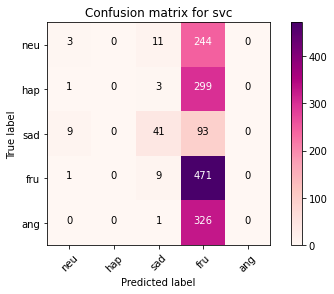

              precision    recall  f1-score   support

         neu       0.21      0.01      0.02       258
         hap       1.00      0.00      0.00       303
         sad       0.63      0.29      0.39       143
         fru       0.33      0.98      0.49       481
         ang       1.00      0.00      0.00       327

    accuracy                           0.34      1512
   macro avg       0.63      0.26      0.18      1512
weighted avg       0.62      0.34      0.20      1512



In [21]:
svc_classifier = LinearSVC()

svc_classifier.fit(X_train_minmax, y_train)

# Predict
pred = svc_classifier.predict(X_test)

# Results
model = 'svc'
display_results(y_test, pred_probs)

with open(home_path + 'skl_res/ICP/svc_classifier_model.pkl', 'wb') as f:
    pickle.dump(svc_classifier, f)

/home/studio-lab-user/.conda/envs/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


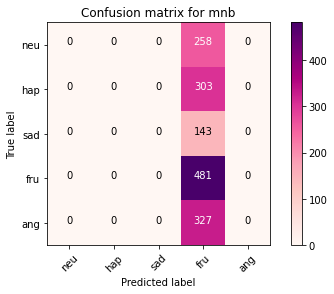

              precision    recall  f1-score   support

         neu       1.00      0.00      0.00       258
         hap       1.00      0.00      0.00       303
         sad       1.00      0.00      0.00       143
         fru       0.32      1.00      0.48       481
         ang       1.00      0.00      0.00       327

    accuracy                           0.32      1512
   macro avg       0.86      0.20      0.10      1512
weighted avg       0.78      0.32      0.15      1512



In [22]:
mnb_classifier = MultinomialNB()

mnb_classifier.fit(X_train_minmax, y_train)

# Predict
pred_probs = mnb_classifier.predict_proba(X_test)

# Results
model = 'mnb'
display_results(y_test, pred_probs)

with open(home_path + 'skl_res/ICP/mnb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

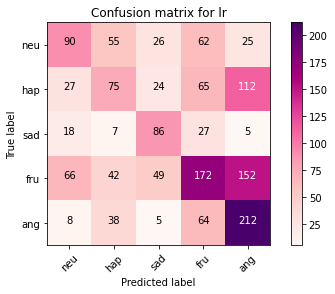

              precision    recall  f1-score   support

         neu       0.43      0.35      0.39       258
         hap       0.35      0.25      0.29       303
         sad       0.45      0.60      0.52       143
         fru       0.44      0.36      0.39       481
         ang       0.42      0.65      0.51       327

    accuracy                           0.42      1512
   macro avg       0.42      0.44      0.42      1512
weighted avg       0.42      0.42      0.41      1512



In [23]:
lr_classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=5000)

lr_classifier.fit(X_train, y_train)

# Predict
pred_probs = lr_classifier.predict_proba(X_test)

# Results
model = 'lr'
display_results(y_test, pred_probs)

with open(home_path + 'skl_res/ICP/lr_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

/home/studio-lab-user/.conda/envs/env/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:28:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:576: 
Parameters: { "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[16:28:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


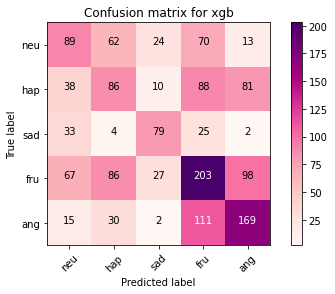

              precision    recall  f1-score   support

         neu       0.37      0.34      0.36       258
         hap       0.32      0.28      0.30       303
         sad       0.56      0.55      0.55       143
         fru       0.41      0.42      0.42       481
         ang       0.47      0.52      0.49       327

    accuracy                           0.41      1512
   macro avg       0.42      0.42      0.42      1512
weighted avg       0.41      0.41      0.41      1512



In [ ]:
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
                                   n_estimators=100, sub_sample=0.8, num_class=len(CLASS_TO_ID),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(X_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(X_test)

# Results
model = 'xgb'
display_results(y_test, pred_probs)

with open(home_path + 'skl_res/ICP/xgb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

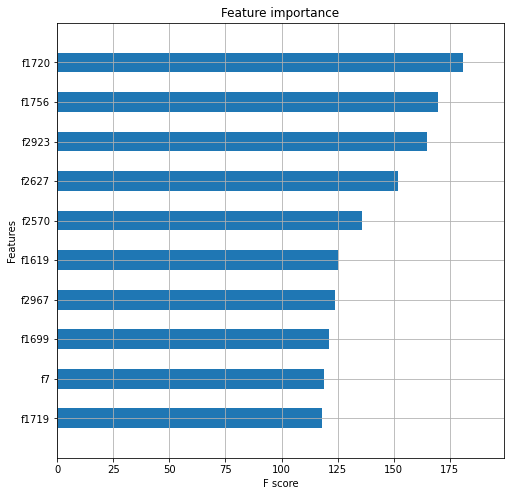

In [ ]:
ax = xgb.plot_importance(xgb_classifier, max_num_features=10, height=0.5, show_values=False)
fig = ax.figure
fig.set_size_inches(8, 8)

In [ ]:
contribution_scores = xgb_classifier.feature_importances_
contribution_scores

array([6.73693794e-05, 7.00032469e-05, 1.07928354e-04, ...,
       4.09034808e-04, 3.12010030e-04, 3.49508598e-04], dtype=float32)

Stats for top 3 features:
[17:03:03] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:576: 
Parameters: { "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/home/studio-lab-user/.conda/envs/env/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:03:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


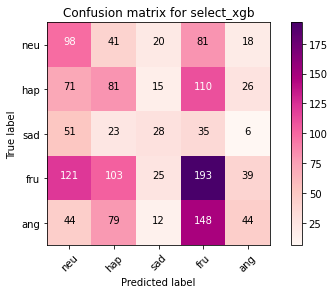

              precision    recall  f1-score   support

         neu       0.25      0.38      0.30       258
         hap       0.25      0.27      0.26       303
         sad       0.28      0.20      0.23       143
         fru       0.34      0.40      0.37       481
         ang       0.33      0.13      0.19       327

    accuracy                           0.29      1512
   macro avg       0.29      0.28      0.27      1512
weighted avg       0.30      0.29      0.28      1512

Stats for top 5 features:
[17:14:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:576: 
Parameters: { "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/home/studio-lab-user/.conda/envs/env/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:14:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


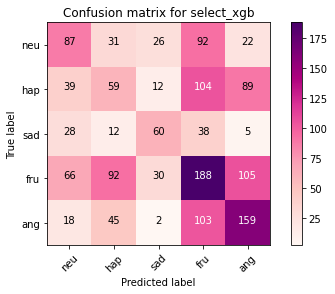

              precision    recall  f1-score   support

         neu       0.37      0.34      0.35       258
         hap       0.25      0.19      0.22       303
         sad       0.46      0.42      0.44       143
         fru       0.36      0.39      0.37       481
         ang       0.42      0.49      0.45       327

    accuracy                           0.37      1512
   macro avg       0.37      0.37      0.37      1512
weighted avg       0.36      0.37      0.36      1512

Stats for top 8 features:
[17:45:48] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:576: 
Parameters: { "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




/home/studio-lab-user/.conda/envs/env/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:45:49] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1645117766796/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


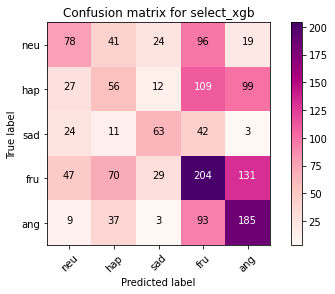

              precision    recall  f1-score   support

         neu       0.42      0.30      0.35       258
         hap       0.26      0.18      0.22       303
         sad       0.48      0.44      0.46       143
         fru       0.38      0.42      0.40       481
         ang       0.42      0.57      0.48       327

    accuracy                           0.39      1512
   macro avg       0.39      0.38      0.38      1512
weighted avg       0.38      0.39      0.38      1512



In [ ]:
top_n = [3, 5, 6, 7, 8]  # number of features
for n in top_n:
    threshold = np.argsort(contribution_scores)[::-1][:n][-1]
    print('Stats for top {} features:'.format(n))
    # Select features using threshold
    selection = SelectFromModel(xgb_classifier, threshold=contribution_scores[threshold], prefit=True)
    select_X_train = selection.transform(X_train)
    select_X_test = selection.transform(X_test)
    
    # Train
    select_xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
                                              n_estimators=1200, sub_sample = 0.8, num_class = len(CLASS_TO_ID),
                                              booster='gbtree', n_jobs=4)
    select_xgb_classifier.fit(select_X_train, y_train)

    # Predict
    pred_probs = select_xgb_classifier.predict_proba(select_X_test)

    # Results
    model = 'select_xgb'
    display_results(y_test, pred_probs)

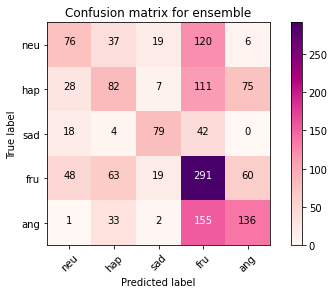

              precision    recall  f1-score   support

         neu       0.44      0.29      0.35       258
         hap       0.37      0.27      0.31       303
         sad       0.63      0.55      0.59       143
         fru       0.40      0.60      0.48       481
         ang       0.49      0.42      0.45       327

    accuracy                           0.44      1512
   macro avg       0.47      0.43      0.44      1512
weighted avg       0.45      0.44      0.43      1512



In [ ]:
# Load predicted probabilities
with open(home_path + 'skl_res/ICP/rf_classifier.pkl', 'rb') as f:
    rf_pred_probs = pickle.load(f)

with open(home_path + 'skl_res/ICP/xgb_classifier.pkl', 'rb') as f:
    xgb_pred_probs = pickle.load(f)
    
with open(home_path + 'skl_res/ICP/svc_classifier_model.pkl', 'rb') as f:
    svc_preds = pickle.load(f)
    
with open(home_path + 'skl_res/ICP/mnb_classifier.pkl', 'rb') as f:
    mnb_pred_probs = pickle.load(f)
    
with open(home_path + 'skl_res/ICP/mlp_classifier.pkl', 'rb') as f:
    mlp_pred_probs = pickle.load(f)
    
with open(home_path + 'skl_res/ICP/lr_classifier.pkl', 'rb') as f:
    lr_pred_probs = pickle.load(f)

#with open(home_path + 'skl_res/ICP/lstm_classifier.pkl', 'rb') as f:
 #   lstm_pred_probs = pickle.load(f)

# Average of the predicted probabilites
ensemble_pred_probs = (xgb_pred_probs + mlp_pred_probs + rf_pred_probs)/3.0
# Show metrics
model = "ensemble"
display_results(y_test, ensemble_pred_probs)